In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler

warnings.simplefilter('ignore')

In [3]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

# データ読み込み

In [4]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
train_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230429_train_landsat2_2000to2020.pkl")
test_landsat_2000to2020 = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230429_test_landsat2_2000to2020.pkl")
train_landsat_norm = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230430_train_landsat3_normalized.pkl")

# 可視化

## 学習データ

In [24]:
def plot_scatter(col1, col2, clip_col1=False, clip_col2=False, low_lim=0.02):
    # 近似線を描く
    # https://horohoronblog.com/?p=203
    def _fit_line(X, Y):
        mx = np.mean(X)
        my = np.mean(Y)

        mxy = np.mean(X*Y)
        mxx = np.mean(X*X)

        a = (mxy - mx * my) / (mxx - mx**2)
        b = my - a * mx

        return np.array([a, b])

    def _clipping(df, col, low_lim=low_lim):
        p01 = df[col].quantile(low_lim)
        p99 = df[col].quantile(1-low_lim)
        df[col] = np.clip(df[col], p01, p99)
        return df

    tmp = train[[col1, col2]]
    if clip_col1:
        tmp = _clipping(tmp, col1)
    if clip_col2:
        tmp = _clipping(tmp, col2)

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot()
    ax.grid(alpha=0.2)
    
    # landsat7
    tmp_ls7 = tmp.loc[train["Landsat_num"]==7, :]
    tmp_ls7.dropna(inplace=True)
    x = tmp_ls7[col1].values
    y = tmp_ls7[col2].values
    ab = _fit_line(x, y)
    liney = ab[0]*x + ab[1]
    corr = np.corrcoef(x, y)[0, 1]
    ax.scatter(x, y, s=4, color="#f6aa00", alpha=0.5, label=f"LS-7 (corr={corr:.04f})")
    ax.plot(x, liney, "--", color="#ff4b00", label="LS-7")

    # landsat8
    tmp_ls8 = tmp.loc[train["Landsat_num"]==8, :]
    tmp_ls8.dropna(inplace=True)
    x = tmp_ls8[col1].values
    y = tmp_ls8[col2].values
    ab = _fit_line(x, y)
    liney = ab[0]*x + ab[1]
    corr = np.corrcoef(x, y)[0, 1]
    ax.scatter(x, y, s=4, color="#4dc4ff", alpha=0.5, label=f"LS-8 (corr={corr:.04f})")
    ax.plot(x, liney, "--", color="#005aff", label="LS-8")

    ax.set_title(f"{col1} vs {col2} ")
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    ax.legend()
    plt.show()

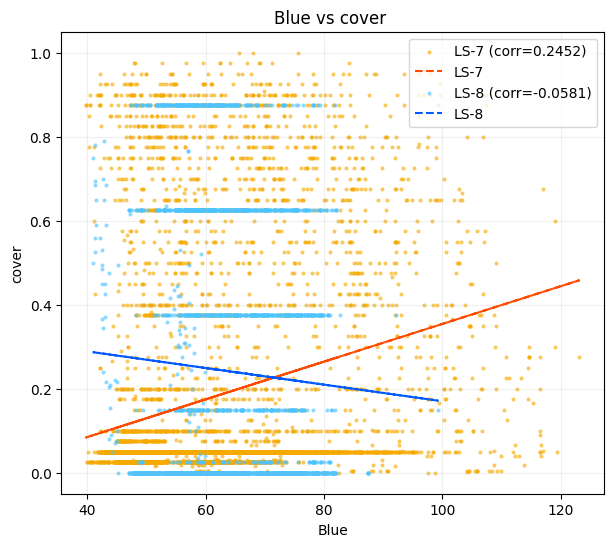

In [25]:
col1 = "Blue"
col2 = "cover"
plot_scatter(col1, col2)

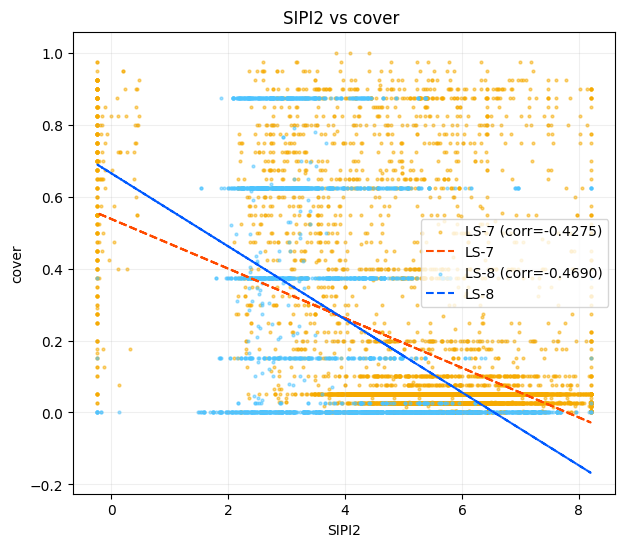

In [27]:
col1 = "SIPI2"
col2 = "cover"
plot_scatter(col1, col2, clip_col1=True)

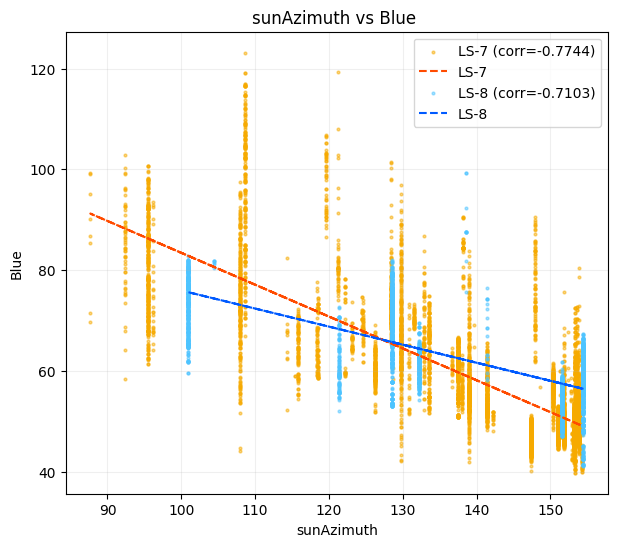

In [28]:
col1 = "sunAzimuth"
col2 = "Blue"
plot_scatter(col1, col2)

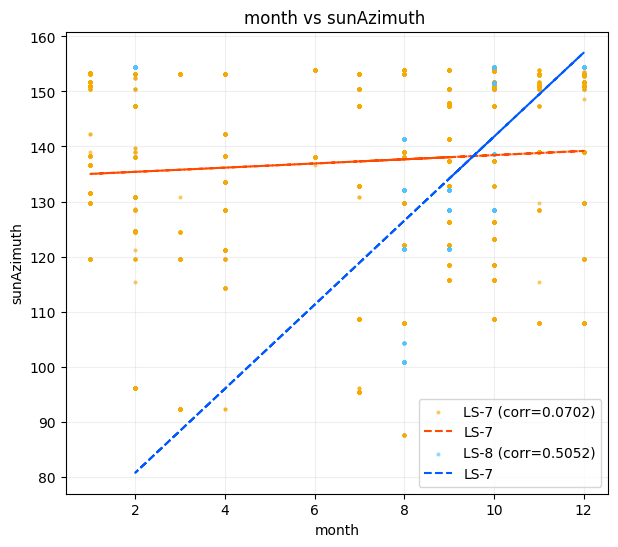

In [13]:
col1 = "month"
col2 = "sunAzimuth"
plot_scatter(col1, col2)

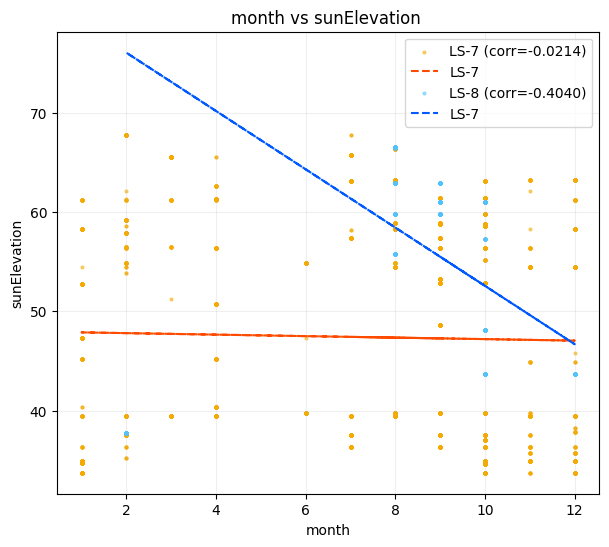

In [14]:
col1 = "month"
col2 = "sunElevation"
plot_scatter(col1, col2)

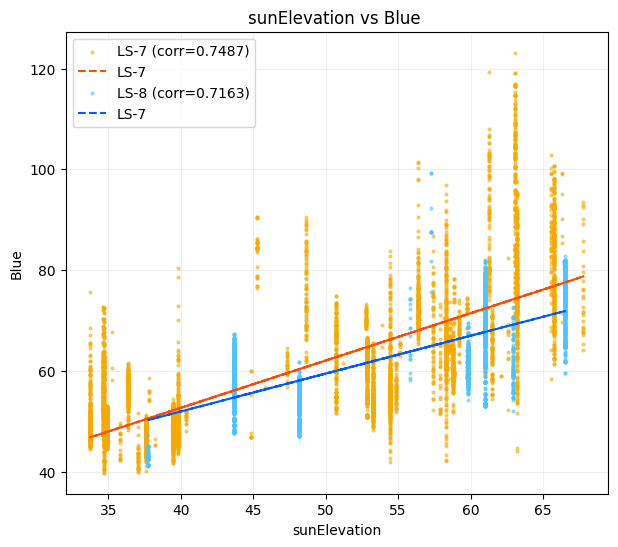

In [15]:
col1 = "sunElevation"
col2 = "Blue"
plot_scatter(col1, col2)

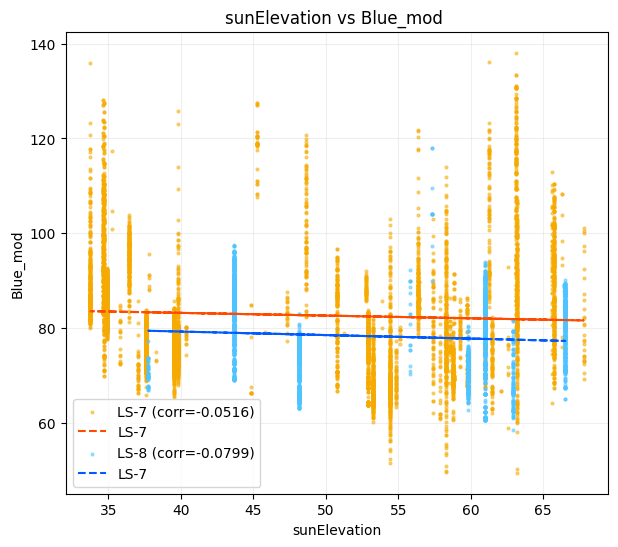

In [16]:
train["Blue_mod"] = train["Blue"] / np.cos(np.radians(90-train["sunElevation"]))

col1 = "sunElevation"
col2 = "Blue_mod"
plot_scatter(col1, col2)

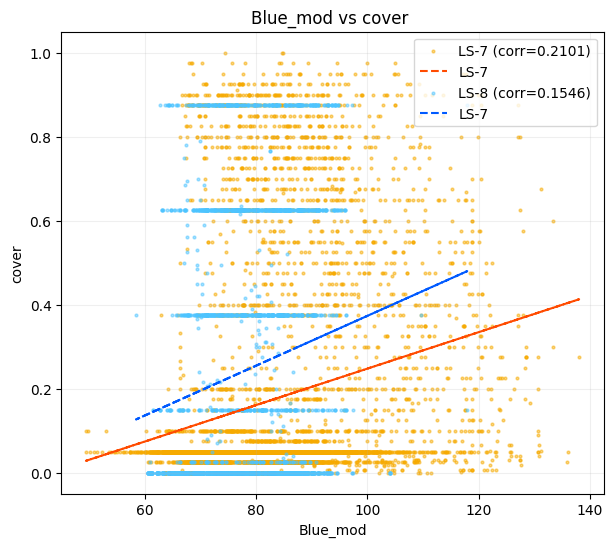

In [17]:
col1 = "Blue_mod"
col2 = "cover"
plot_scatter(col1, col2)

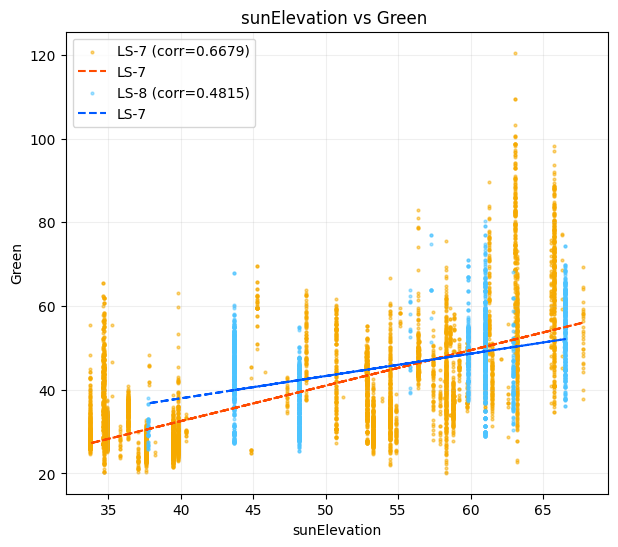

In [19]:
col1 = "sunElevation"
col2 = "Green"
plot_scatter(col1, col2)

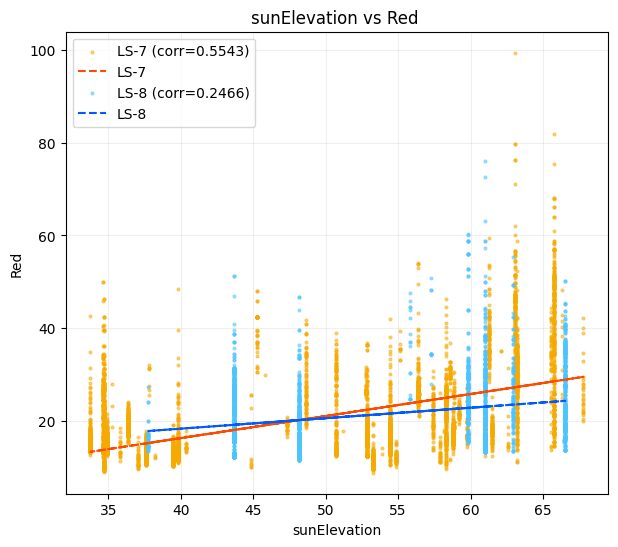

In [29]:
col1 = "sunElevation"
col2 = "Red"
plot_scatter(col1, col2)

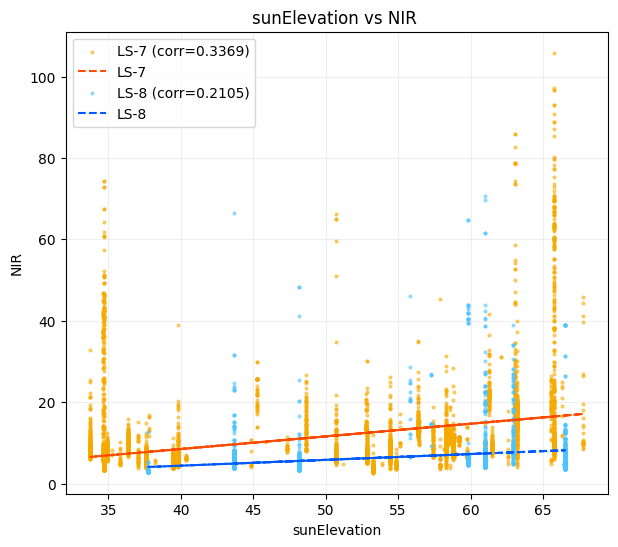

In [30]:
col1 = "sunElevation"
col2 = "NIR"
plot_scatter(col1, col2)

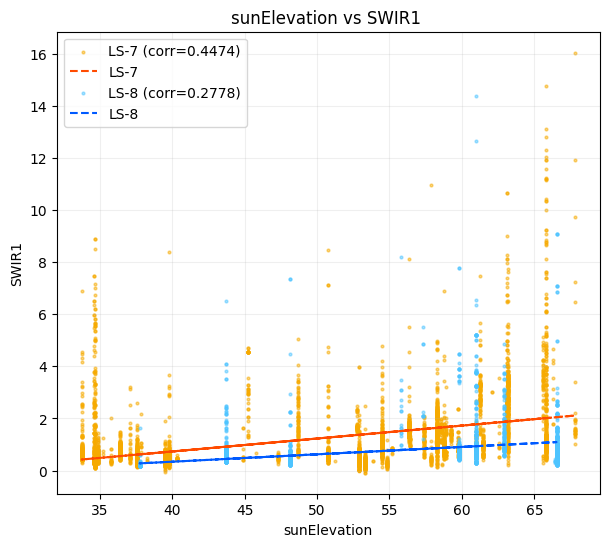

In [31]:
col1 = "sunElevation"
col2 = "SWIR1"
plot_scatter(col1, col2)

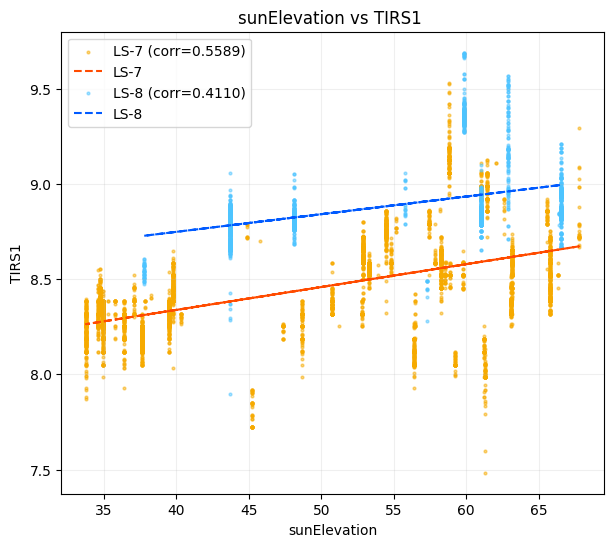

In [32]:
col1 = "sunElevation"
col2 = "TIRS1"
plot_scatter(col1, col2)

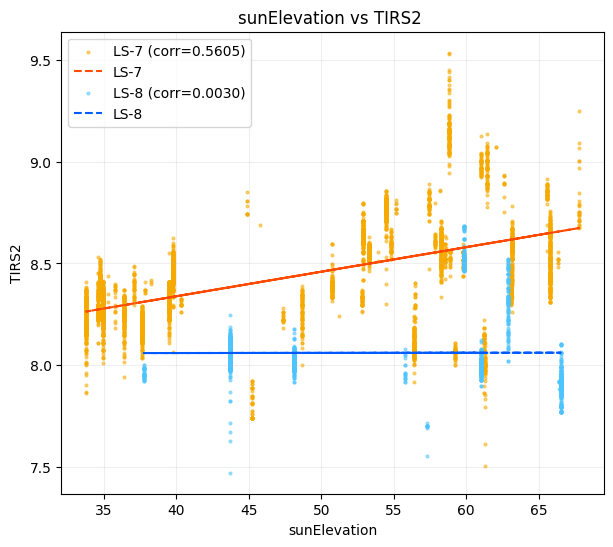

In [33]:
col1 = "sunElevation"
col2 = "TIRS2"
plot_scatter(col1, col2)

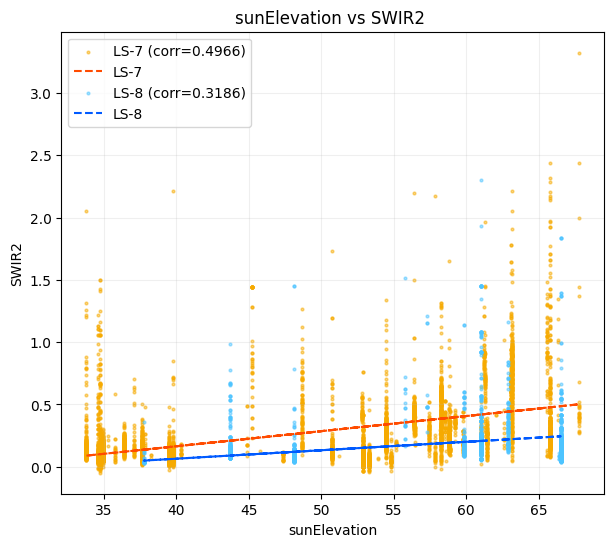

In [34]:
col1 = "sunElevation"
col2 = "SWIR2"
plot_scatter(col1, col2)

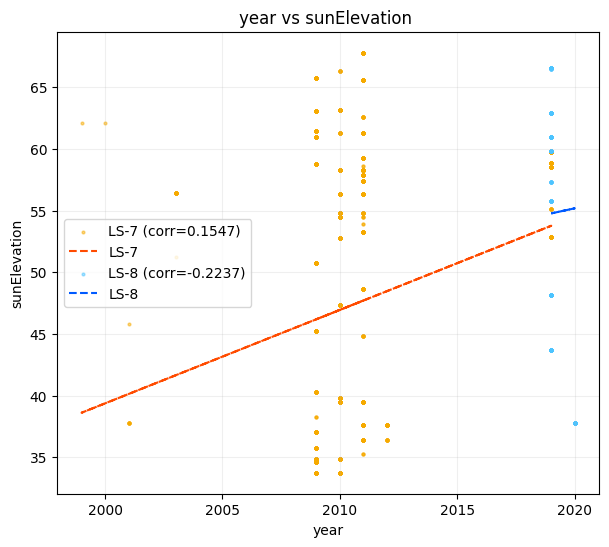

In [35]:
col1 = "year"
col2 = "sunElevation"
plot_scatter(col1, col2)

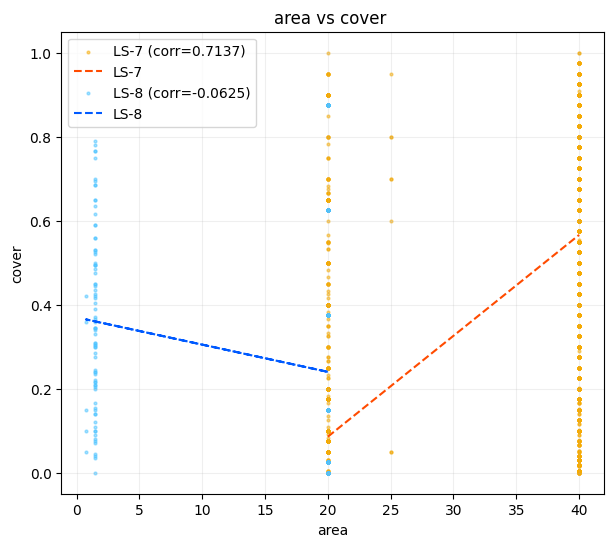

In [36]:
col1 = "area"
col2 = "cover"
plot_scatter(col1, col2)

## Landsatの特徴抽出後

In [ ]:
def plot_scatter_mod(col1, col2):
    # 近似線を描く
    # https://horohoronblog.com/?p=203
    def _fit_line(X, Y):
        mx = np.mean(X)
        my = np.mean(Y)

        mxy = np.mean(X*Y)
        mxx = np.mean(X*X)

        a = (mxy - mx * my) / (mxx - mx**2)
        b = my - a * mx

        return np.array([a, b])

    tmp = train_landsat_2000to2020[[col1, col2]].dropna()
    x = tmp[col1].values
    y = tmp[col2].values
    ab = _fit_line(x, y)
    liney = ab[0]*x + ab[1]

    corr = np.corrcoef(x, y)[0, 1]

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot()
    ax.grid(alpha=0.2)
    ax.scatter(x, y, s=4, alpha=0.5)
    ax.plot(x, liney, "--", color="gray")
    ax.set_title(f"{col1} vs {col2} (corr={corr:.04f})")
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)

    plt.show()

In [ ]:
train_landsat_2000to2020["cover"] = train["cover"]

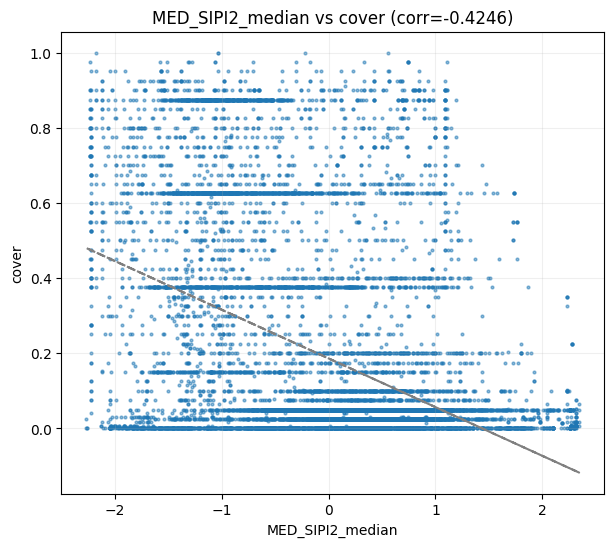

In [ ]:
col1 = "MED_SIPI2_median"
col2 = "cover"
plot_scatter_mod(col1, col2)

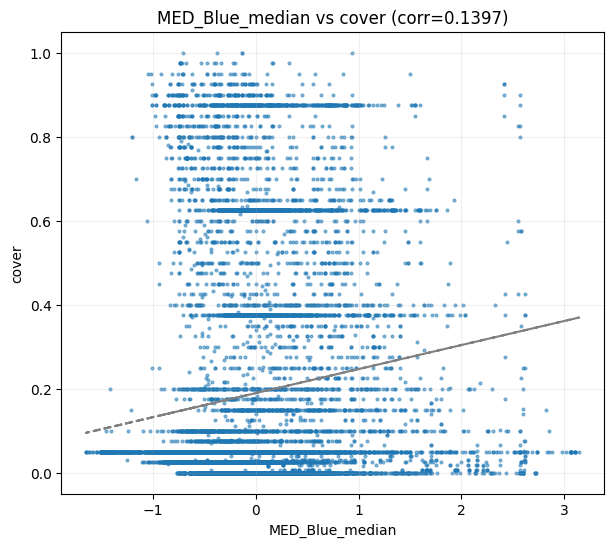

In [ ]:
col1 = "MED_Blue_median"
col2 = "cover"
plot_scatter_mod(col1, col2)

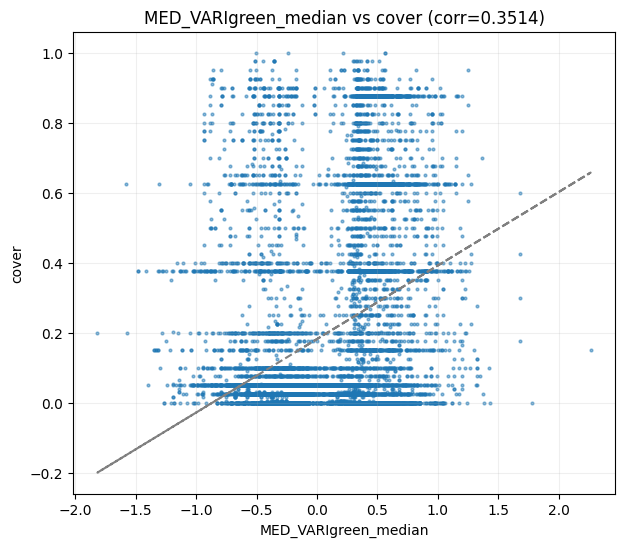

In [ ]:
col1 = "MED_VARIgreen_median"
col2 = "cover"
plot_scatter_mod(col1, col2)

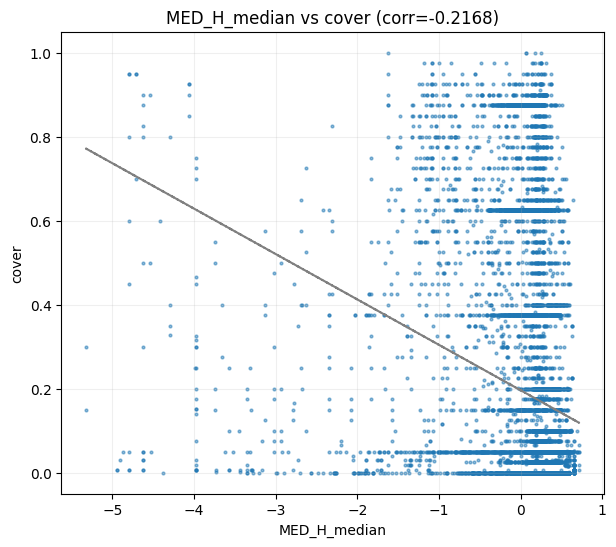

In [ ]:
col1 = "MED_H_median"
col2 = "cover"
plot_scatter_mod(col1, col2)

## Landsatの特徴抽出後2

In [ ]:
def plot_scatter_mod2(col1, col2):
    # 近似線を描く
    # https://horohoronblog.com/?p=203
    def _fit_line(X, Y):
        mx = np.mean(X)
        my = np.mean(Y)

        mxy = np.mean(X*Y)
        mxx = np.mean(X*X)

        a = (mxy - mx * my) / (mxx - mx**2)
        b = my - a * mx

        return np.array([a, b])

    tmp = train_landsat_norm[[col1, col2]].dropna()
    x = tmp[col1].values
    y = tmp[col2].values
    ab = _fit_line(x, y)
    liney = ab[0]*x + ab[1]

    corr = np.corrcoef(x, y)[0, 1]

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot()
    ax.grid(alpha=0.2)
    ax.scatter(x, y, s=4, alpha=0.5)
    ax.plot(x, liney, "--", color="gray")
    ax.set_title(f"{col1} vs {col2} (corr={corr:.04f})")
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)

    plt.show()

In [ ]:
train_landsat_norm["cover"] = train["cover"]

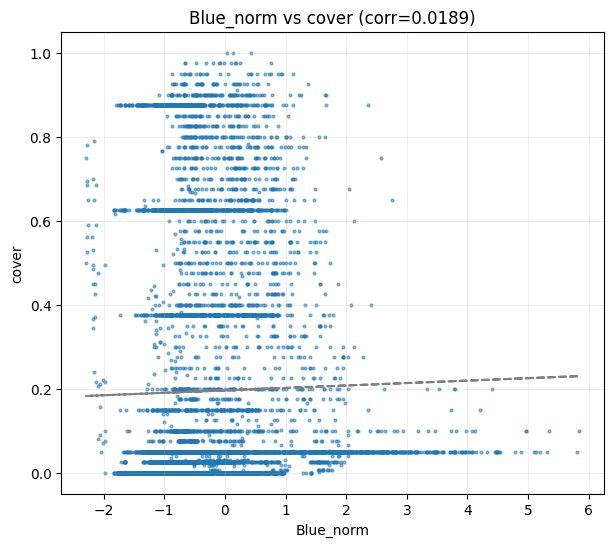

In [ ]:
col1 = "Blue_norm"
col2 = "cover"
plot_scatter_mod2(col1, col2)

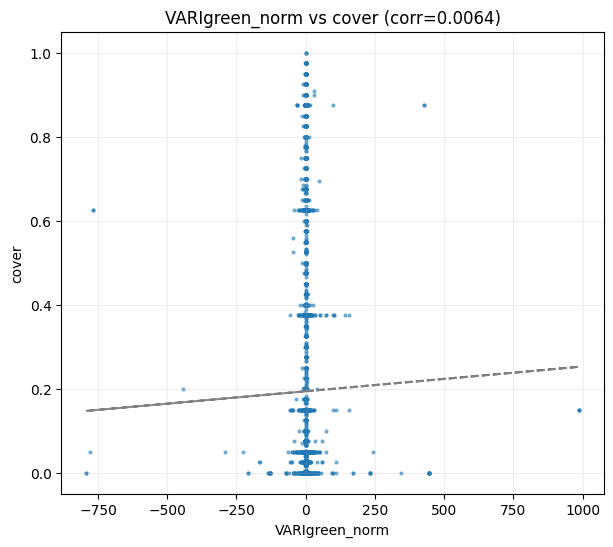

In [ ]:
col1 = "VARIgreen_norm"
col2 = "cover"
plot_scatter_mod2(col1, col2)